#  Filtro di Kalman

#### Andrea Corvaglia (802487)
    
    
  
    

##   Import delle librerie

In [6]:
import numpy as np
from numpy.linalg import inv 
from numpy.random import randn 
import matplotlib.pyplot as plt
from math import sqrt

# Funzioni

### Funzione fase di predizione

Prende in argomento lo stato del sistema `X`, la matrice delle covarianze del sistema `P`, la matrice di transizione `F`, la matrice delle varianze degli errori del processo `Q` e gli elementi di input `B` (matrice) e `U` (vettore).
Restituisce il vettore `X` e la matrice `P` aggiornati.

In [7]:
def kf_predict(X, P, F, Q, B, U):
    # Fx+Bu | Aggiorna lo stato
    X = np.dot(F, X) + np.dot(B, U)
    # FPFt + Q | aggiorna la matrice delle covarianze 
    # sommando il contributo dell'incertezza della previsione e della dinamica del processo
    P = np.dot(F, np.dot(P, F.T)) + Q
    return(X,P) 

### Funzione fase di aggiornamento

Prende in argomento lo stato del sistema `X`, la matrice delle covarianze del sistema `P`, la matrice di trasformazione `H` e la matrice delle varianze dell'errore sulle misure. Restituisce il vettore `X` e la matrice `P` aggiornati.


In [8]:
def kf_update(X, P, Y, H, R):
    # Proietta lo stato nello spazio di misura
    IM = np.dot(H, X)
    # Matrice di covarianza totale: processo + misura
    IS = R + np.dot(H, np.dot(P, H.T))
    # Calcolo del coefficiente di guadagno di Kalman K = P*Ht*IS^-1 
    # cov processo su totale -> da una idea di quanto ci si può fidare della predizione
    K = np.dot(P, np.dot(H.T, inv(IS)))
    # Riaggiorniamo media e covarianza dello stato
    X = X + np.dot(K, (Y-IM)) # parametrizzazione del segmento Y->IM tramite K
    P = P - np.dot(K, np.dot(IS, K.T)) # prondotto delle covarianze
    return (X,P)

## Simulazione di movimento

### Funzione di simulazione singolo movimento

Prende in input il vettore di stato `X` al tempo $t$, la varianza della misura `z_var` , la varianza del processo `process_var` e l'intervallo di tempo.
Genera la posizione successiva estrapolando la posizione attuale dal vettore di stato e calcolando lo spostamento a partire dalla velocità ugualmente estrapolata. Applica, però, alle componenti della velocità un errore casuale estrapolato da una gaussiana di media nulla e varianza `process_var` per rendere conto dell'incertezza del processo. L'errore lungo l'asse x ha una varianza dieci volte minore rispetto al suo omologo lungo y, in modo da avere un moto unidirezionale lungo le ascisse (Per avere un plot della traiettoria più chiaro). In questo modo sono generate le posizioni reali dell'oggetto al tempo $t+dt$, a partire dalle quali viene simulata una misura, aggiungendo rumore casuale con varianza `z_var`, identica per le due coordinate.
Viene restituito il vettore di stato al tempo $t+dt$ con le posizioni e la velocità aggiornati e il vettore della misura corrispondente.

In [9]:
def move(X,z_var,process_var,dt=.1) :
    "Simula un singolo movimento"
    pos = X[:2]
    vel = X[2:] 
    p_std = sqrt(process_var)
    z_std = sqrt(z_var)
    vel[0]+= 0.1*randn()*p_std 
    vel[1]+= randn()*p_std 
    pos[0] += vel[0]*dt
    pos[1] += vel[1]*dt
    z = [pos[0] + randn()*z_std , pos[1] + randn()*z_std]
    X = np.concatenate((pos,vel))
    return X,z

### Funzione di simulazione della traiettoria

Prende in argomento il numero di passi `N_iter`, la varianza della misura `z_var` , la varianza del processo `process_var` e l'intervallo di tempo. 
Semplicemente reitera la funzione **move** per `N_iter` volte, salvando posizoni reali e misurate in due vettore che restituisce in output.

In [10]:
def simulator(N_iter=500,z_var=0.5,process_var=0.01,dt=0.1):
    "Genera una sequenza di movimenti, restituendo le posizioni vere e misurate"
    # Inizializzazione 
    X = np.array([0.,0.,1.,1.])
    real_pos = []
    misured_pos = []
    for i in range(N_iter):
        X,z = move(X,z_var,process_var,dt)
        real_pos.append(X[:2])
        misured_pos.append(z)
    return np.array(real_pos), np.array(misured_pos)

# Applicazione

In questa sezione verranno inizializzati i parametri fondamentali del problema e generata la sequenza simulata di posizioni reali e le corrispondenti misure (si noti che il Filtro di Kalman essendo un algoritmo di filtraggio funziona senza problemi online, ma viene comunque generata prima la sequenza solo per ragioni di comodità). Successivamente verrà applicato l'algoritmo di filtraggio per ottenere una sequenza di posizioni a partire dalle misure e dai parametri precedentemente inizializzati.
Nell'ultima parte verrà mostrato un plot per confrontare la traiettoria filtrata con quella misurata e quella reale. Verrà inoltre analizzato l'andamento della varianza stimata dal modello e dei residui.

### Set seed per generazione casuale.

In [11]:
seed = 123

### Inizializzazione dei parametri fondamentali

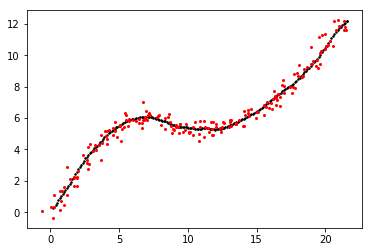

In [18]:
# Intervallo temporale del movimento
dt = 0.1
z_var=0.1 # incertezza sulla misura 
process_var=0.01 # incertezza del processo 
# Numeor di iterazioni nel Filtro di Kalman 
N_iter =200
###################################################
# Generazione della traiettoria e delle misure
np.random.seed(seed)
real,measured = simulator(N_iter,z_var,process_var,dt)
plt.plot(real[:,0],real[:,1],".",c="k",ms=3)
plt.plot(measured[:,0],measured[:,1],".",c="r",ms=4)
###################################################
# Vettore di stato 
X = np.array([[real[0,0]], [real[0,1]], [1.], [1.]])
# Matrice covarianze dello stato
P = np.diag((1, 1, 10, 10))
# Matrice di transizione
F = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
# Matrice covarianze errore processo
Q = np.array([[0, 0, dt*process_var/100 , 0], [0, 0, 0, dt*process_var], [0.1*process_var/100, 0, process_var/100, 0], [0, 0.1*process_var, 0, process_var]])
# Matrice di input
B = np.eye(X.shape[0])
U = np.zeros((X.shape[0],1)) 
# Matrici di misura
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]]) 
R =  np.diag((z_var, z_var))               

### Applicazione del filtro

In [13]:
sigma= np.zeros((4,N_iter)) # matrice per salvare i vari valori delle varianze
xx = np.zeros(N_iter)
yy = np.zeros(N_iter)
#######################
residual = []
var = [P.diagonal()[0]]
#######################
for i in range(0, N_iter):
    Y = np.array([[measured[i,0]],[measured[i,1]]])
    res = real[i,1]-X[1]
    residual.append(res)
    xx[i]=X[0]
    yy[i]=X[1]
    sigma[:,i]= P.diagonal()
    var.append(P.diagonal()[0])
    (X, P) = kf_predict(X, P, F, Q, B, U)
    (X, P) = kf_update(X, P, Y, H, R)
var = np.array(var)

## Plot

In [14]:
tit = ["$x$","$y$","$v_{x}$","$v_{y}$"]

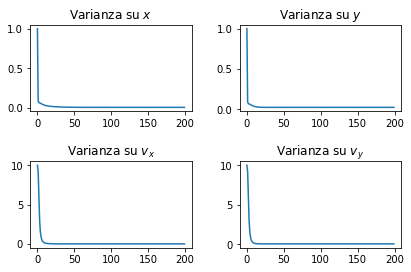

In [15]:
for i in range(4):
    plt.subplot(str(22)+str(i+1))
    plt.tight_layout(pad = 1.5)
    plt.title("Varianza su "+tit[i])
    plt.plot(sigma[i,:])
#plt.savefig("var.png",dpi=200)

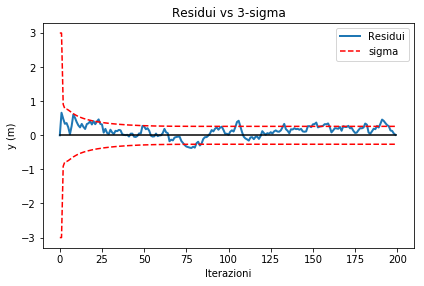

In [16]:
plt.figure()
plt.title("Residui vs 3-sigma")
plt.tight_layout(pad = 1.5)
plt.xlabel("Iterazioni")
plt.ylabel("y (m)")

plt.plot(residual,label="Residui",lw=2)
plt.plot(N_iter*[0],"black")
plt.plot(3*np.sqrt(var),linestyle='dashed',color="red",label = "sigma")
plt.plot(-3*np.sqrt(var),linestyle='dashed',color="red")
plt.plot(sigma[1,1])
plt.legend()
#plt.savefig("Residui.png",dpi=200)

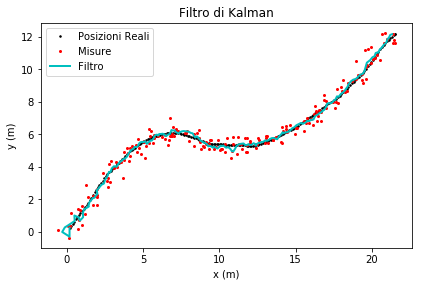

In [17]:
plt.figure()
plt.title("Filtro di Kalman")
plt.tight_layout(pad = 1.5)
plt.xlabel("x (m)")
plt.ylabel("y (m)")

plt.plot(real[:,0],real[:,1],".",label="Posizioni Reali",c="k",ms=3)
plt.plot(measured[:,0],measured[:,1],".",label="Misure",c="r",ms=4)
plt.plot(xx,yy,label="Filtro",lw=2,c="c")
plt.legend()
#plt.savefig("Filtro.png",dpi=200)